In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                                          | 0/50000 [00:00<?, ?it/s]

  9%|████████████▏                                                                                                                               | 4337/50000 [00:00<00:01, 43361.87it/s]

 17%|████████████████████████▎                                                                                                                   | 8677/50000 [00:00<00:00, 43383.29it/s]

 26%|████████████████████████████████████▍                                                                                                      | 13117/50000 [00:00<00:00, 43845.24it/s]

 35%|████████████████████████████████████████████████▋                                                                                          | 17517/50000 [00:00<00:00, 43903.87it/s]

 44%|█████████████████████████████████████████████████████████████                                                                              | 21968/50000 [00:00<00:00, 44118.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████▎                                                                 | 26381/50000 [00:00<00:00, 44121.79it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                     | 30794/50000 [00:00<00:00, 42912.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 35211/50000 [00:00<00:00, 43302.27it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 39654/50000 [00:00<00:00, 43648.68it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44104/50000 [00:01<00:00, 43906.07it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 48543/50000 [00:01<00:00, 44051.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43785.88it/s]

Files already downloaded and verified


  0%|                                                                                                                                                          | 0/10000 [00:00<?, ?it/s]

 43%|███████████████████████████████████████████████████████████▊                                                                                | 4270/10000 [00:00<00:00, 42696.17it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8612/10000 [00:00<00:00, 43115.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42945.83it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 za51lfb3


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                            | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/313 [00:00<03:46,  1.38it/s]

  1%|█▉                                                                                                                                                  | 4/313 [00:00<00:53,  5.77it/s]

  2%|███▎                                                                                                                                                | 7/313 [00:00<00:31,  9.61it/s]

  3%|████▋                                                                                                                                              | 10/313 [00:01<00:23, 12.96it/s]

  4%|██████                                                                                                                                             | 13/313 [00:01<00:19, 15.69it/s]

  5%|███████▌                                                                                                                                           | 16/313 [00:01<00:16, 17.83it/s]

  6%|████████▉                                                                                                                                          | 19/313 [00:01<00:15, 19.46it/s]

  7%|██████████▎                                                                                                                                        | 22/313 [00:01<00:14, 20.69it/s]

  8%|███████████▋                                                                                                                                       | 25/313 [00:01<00:13, 21.58it/s]

  9%|█████████████▏                                                                                                                                     | 28/313 [00:01<00:12, 22.22it/s]

 10%|██████████████▌                                                                                                                                    | 31/313 [00:02<00:12, 22.66it/s]

 11%|███████████████▉                                                                                                                                   | 34/313 [00:02<00:12, 22.98it/s]

 12%|█████████████████▍                                                                                                                                 | 37/313 [00:02<00:11, 23.19it/s]

 13%|██████████████████▊                                                                                                                                | 40/313 [00:02<00:11, 23.34it/s]

 14%|████████████████████▏                                                                                                                              | 43/313 [00:02<00:11, 23.47it/s]

 15%|█████████████████████▌                                                                                                                             | 46/313 [00:02<00:11, 23.57it/s]

 16%|███████████████████████                                                                                                                            | 49/313 [00:02<00:11, 23.63it/s]

 17%|████████████████████████▍                                                                                                                          | 52/313 [00:02<00:11, 23.67it/s]

 18%|█████████████████████████▊                                                                                                                         | 55/313 [00:03<00:10, 23.72it/s]

 19%|███████████████████████████▏                                                                                                                       | 58/313 [00:03<00:10, 23.74it/s]

 19%|████████████████████████████▋                                                                                                                      | 61/313 [00:03<00:10, 23.76it/s]

 20%|██████████████████████████████                                                                                                                     | 64/313 [00:03<00:10, 23.76it/s]

 21%|███████████████████████████████▍                                                                                                                   | 67/313 [00:03<00:10, 23.68it/s]

 22%|████████████████████████████████▉                                                                                                                  | 70/313 [00:03<00:10, 23.72it/s]

 23%|██████████████████████████████████▎                                                                                                                | 73/313 [00:03<00:10, 23.73it/s]

 24%|███████████████████████████████████▋                                                                                                               | 76/313 [00:03<00:09, 23.75it/s]

 25%|█████████████████████████████████████                                                                                                              | 79/313 [00:04<00:09, 23.76it/s]

 26%|██████████████████████████████████████▌                                                                                                            | 82/313 [00:04<00:09, 23.76it/s]

 27%|███████████████████████████████████████▉                                                                                                           | 85/313 [00:04<00:09, 23.76it/s]

 28%|█████████████████████████████████████████▎                                                                                                         | 88/313 [00:04<00:09, 23.76it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 91/313 [00:04<00:09, 23.76it/s]

 30%|████████████████████████████████████████████▏                                                                                                      | 94/313 [00:04<00:09, 23.66it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 97/313 [00:04<00:09, 23.68it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 100/313 [00:04<00:08, 23.70it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 103/313 [00:05<00:08, 23.71it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 106/313 [00:05<00:08, 23.72it/s]

 35%|██████████████████████████████████████████████████▊                                                                                               | 109/313 [00:05<00:08, 23.74it/s]

 36%|████████████████████████████████████████████████████▏                                                                                             | 112/313 [00:05<00:08, 23.73it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 115/313 [00:05<00:08, 23.73it/s]

 38%|███████████████████████████████████████████████████████                                                                                           | 118/313 [00:05<00:08, 23.73it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 121/313 [00:05<00:08, 23.73it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                        | 124/313 [00:05<00:07, 23.72it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                      | 127/313 [00:06<00:07, 23.72it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                     | 130/313 [00:06<00:07, 23.72it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                    | 133/313 [00:06<00:07, 23.71it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                  | 136/313 [00:06<00:07, 23.71it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 139/313 [00:06<00:07, 23.71it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                               | 142/313 [00:06<00:07, 23.72it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 145/313 [00:06<00:07, 23.72it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                             | 148/313 [00:06<00:06, 23.72it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 151/313 [00:07<00:06, 23.72it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 154/313 [00:07<00:06, 23.71it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                        | 157/313 [00:07<00:06, 23.71it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                       | 160/313 [00:07<00:06, 23.72it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 163/313 [00:07<00:06, 23.70it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 166/313 [00:07<00:06, 23.70it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 169/313 [00:07<00:06, 23.70it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 172/313 [00:07<00:05, 23.68it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                | 175/313 [00:08<00:05, 23.66it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                               | 178/313 [00:08<00:05, 23.65it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 181/313 [00:08<00:05, 23.50it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 184/313 [00:08<00:05, 23.55it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 187/313 [00:08<00:05, 23.58it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 190/313 [00:08<00:05, 23.61it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                        | 193/313 [00:08<00:05, 23.63it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 196/313 [00:08<00:04, 23.63it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 199/313 [00:09<00:04, 23.65it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 202/313 [00:09<00:04, 23.65it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 205/313 [00:09<00:04, 23.66it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 208/313 [00:09<00:04, 23.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 211/313 [00:09<00:04, 23.50it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 214/313 [00:09<00:04, 23.51it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 217/313 [00:09<00:04, 23.56it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 220/313 [00:09<00:03, 23.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 223/313 [00:10<00:03, 23.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 226/313 [00:10<00:03, 23.61it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 229/313 [00:10<00:03, 23.63it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 232/313 [00:10<00:03, 23.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 235/313 [00:10<00:03, 23.64it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 238/313 [00:10<00:03, 23.64it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 241/313 [00:10<00:03, 23.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 244/313 [00:10<00:02, 23.64it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 247/313 [00:11<00:02, 23.65it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 250/313 [00:11<00:02, 23.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 253/313 [00:11<00:02, 23.62it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 256/313 [00:11<00:02, 23.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 259/313 [00:11<00:02, 23.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 262/313 [00:11<00:02, 23.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 265/313 [00:11<00:02, 23.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 268/313 [00:12<00:01, 23.63it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 271/313 [00:12<00:01, 23.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 274/313 [00:12<00:01, 23.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 277/313 [00:12<00:01, 23.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 280/313 [00:12<00:01, 23.57it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 283/313 [00:12<00:01, 23.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 286/313 [00:12<00:01, 23.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 289/313 [00:12<00:01, 23.60it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 292/313 [00:13<00:00, 23.61it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 295/313 [00:13<00:00, 23.61it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 298/313 [00:13<00:00, 23.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 301/313 [00:13<00:00, 23.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 304/313 [00:13<00:00, 23.61it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 307/313 [00:13<00:00, 23.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 310/313 [00:13<00:00, 23.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.43it/s]

train - OK


  0%|                                                                                                                                                             | 0/79 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                   | 1/79 [00:00<00:10,  7.20it/s]

  5%|███████▌                                                                                                                                             | 4/79 [00:00<00:04, 16.31it/s]

  9%|█████████████▏                                                                                                                                       | 7/79 [00:00<00:03, 19.48it/s]

 13%|██████████████████▋                                                                                                                                 | 10/79 [00:00<00:03, 21.00it/s]

 16%|████████████████████████▎                                                                                                                           | 13/79 [00:00<00:03, 21.86it/s]

 20%|█████████████████████████████▉                                                                                                                      | 16/79 [00:00<00:02, 22.38it/s]

 24%|███████████████████████████████████▌                                                                                                                | 19/79 [00:00<00:02, 22.71it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 22/79 [00:01<00:02, 22.92it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 25/79 [00:01<00:02, 23.07it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 28/79 [00:01<00:02, 23.17it/s]

 39%|██████████████████████████████████████████████████████████                                                                                          | 31/79 [00:01<00:02, 23.15it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                    | 34/79 [00:01<00:01, 23.22it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 37/79 [00:01<00:01, 23.29it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                         | 40/79 [00:01<00:01, 23.33it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                   | 43/79 [00:01<00:01, 23.35it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                             | 46/79 [00:02<00:01, 23.37it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 49/79 [00:02<00:01, 23.37it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 52/79 [00:02<00:01, 23.37it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 55/79 [00:02<00:01, 23.37it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 58/79 [00:02<00:00, 23.38it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 61/79 [00:02<00:00, 23.38it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 64/79 [00:02<00:00, 23.38it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 67/79 [00:02<00:00, 23.35it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 70/79 [00:03<00:00, 23.36it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 73/79 [00:03<00:00, 23.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76/79 [00:03<00:00, 23.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 22.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 22.35it/s]

val - OK


  0%|                                                                                                                                                             | 0/79 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                   | 1/79 [00:00<00:11,  7.07it/s]

  5%|███████▌                                                                                                                                             | 4/79 [00:00<00:04, 16.19it/s]

  9%|█████████████▏                                                                                                                                       | 7/79 [00:00<00:03, 19.42it/s]

 13%|██████████████████▋                                                                                                                                 | 10/79 [00:00<00:03, 21.00it/s]

 16%|████████████████████████▎                                                                                                                           | 13/79 [00:00<00:03, 21.90it/s]

 20%|█████████████████████████████▉                                                                                                                      | 16/79 [00:00<00:02, 22.43it/s]

 24%|███████████████████████████████████▌                                                                                                                | 19/79 [00:00<00:02, 22.70it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 22/79 [00:01<00:02, 22.96it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 25/79 [00:01<00:02, 23.13it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 28/79 [00:01<00:02, 23.24it/s]

 39%|██████████████████████████████████████████████████████████                                                                                          | 31/79 [00:01<00:02, 23.33it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                    | 34/79 [00:01<00:01, 23.38it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 37/79 [00:01<00:01, 23.38it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                         | 40/79 [00:01<00:01, 23.38it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                   | 43/79 [00:01<00:01, 23.39it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                             | 46/79 [00:02<00:01, 23.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 49/79 [00:02<00:01, 23.38it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 52/79 [00:02<00:01, 23.36it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 55/79 [00:02<00:01, 23.38it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 58/79 [00:02<00:00, 23.38it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 61/79 [00:02<00:00, 23.39it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 64/79 [00:02<00:00, 23.40it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 67/79 [00:02<00:00, 23.40it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 70/79 [00:03<00:00, 23.40it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 73/79 [00:03<00:00, 23.40it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76/79 [00:03<00:00, 23.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 24.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 22.61it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/469 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/469 [00:00<01:08,  6.79it/s]

  1%|█▎                                                                                                                                                  | 4/469 [00:00<00:29, 15.94it/s]

  1%|██▏                                                                                                                                                 | 7/469 [00:00<00:23, 19.27it/s]

  2%|███▏                                                                                                                                               | 10/469 [00:00<00:21, 20.93it/s]

  3%|████                                                                                                                                               | 13/469 [00:00<00:20, 21.86it/s]

  3%|█████                                                                                                                                              | 16/469 [00:00<00:20, 22.43it/s]

  4%|█████▉                                                                                                                                             | 19/469 [00:00<00:19, 22.80it/s]

  5%|██████▉                                                                                                                                            | 22/469 [00:01<00:19, 23.03it/s]

  5%|███████▊                                                                                                                                           | 25/469 [00:01<00:19, 23.18it/s]

  6%|████████▊                                                                                                                                          | 28/469 [00:01<00:18, 23.29it/s]

  7%|█████████▋                                                                                                                                         | 31/469 [00:01<00:18, 23.36it/s]

  7%|██████████▋                                                                                                                                        | 34/469 [00:01<00:18, 23.41it/s]

  8%|███████████▌                                                                                                                                       | 37/469 [00:01<00:18, 23.45it/s]

  9%|████████████▌                                                                                                                                      | 40/469 [00:01<00:18, 23.37it/s]

  9%|█████████████▍                                                                                                                                     | 43/469 [00:01<00:18, 23.41it/s]

 10%|██████████████▍                                                                                                                                    | 46/469 [00:02<00:18, 23.45it/s]

 10%|███████████████▎                                                                                                                                   | 49/469 [00:02<00:17, 23.47it/s]

 11%|████████████████▎                                                                                                                                  | 52/469 [00:02<00:17, 23.49it/s]

 12%|█████████████████▏                                                                                                                                 | 55/469 [00:02<00:17, 23.50it/s]

 12%|██████████████████▏                                                                                                                                | 58/469 [00:02<00:17, 23.51it/s]

 13%|███████████████████                                                                                                                                | 61/469 [00:02<00:17, 23.52it/s]

 14%|████████████████████                                                                                                                               | 64/469 [00:02<00:17, 23.52it/s]

 14%|█████████████████████                                                                                                                              | 67/469 [00:02<00:17, 23.53it/s]

 15%|█████████████████████▉                                                                                                                             | 70/469 [00:03<00:16, 23.53it/s]

 16%|██████████████████████▉                                                                                                                            | 73/469 [00:03<00:16, 23.51it/s]

 16%|███████████████████████▊                                                                                                                           | 76/469 [00:03<00:16, 23.46it/s]

 17%|████████████████████████▊                                                                                                                          | 79/469 [00:03<00:16, 23.48it/s]

 17%|█████████████████████████▋                                                                                                                         | 82/469 [00:03<00:16, 23.49it/s]

 18%|██████████████████████████▋                                                                                                                        | 85/469 [00:03<00:16, 23.50it/s]

 19%|███████████████████████████▌                                                                                                                       | 88/469 [00:03<00:16, 23.50it/s]

 19%|████████████████████████████▌                                                                                                                      | 91/469 [00:03<00:16, 23.50it/s]

 20%|█████████████████████████████▍                                                                                                                     | 94/469 [00:04<00:15, 23.50it/s]

 21%|██████████████████████████████▍                                                                                                                    | 97/469 [00:04<00:15, 23.51it/s]

 21%|███████████████████████████████▏                                                                                                                  | 100/469 [00:04<00:15, 23.51it/s]

 22%|████████████████████████████████                                                                                                                  | 103/469 [00:04<00:15, 23.52it/s]

 23%|████████████████████████████████▉                                                                                                                 | 106/469 [00:04<00:15, 23.51it/s]

 23%|█████████████████████████████████▉                                                                                                                | 109/469 [00:04<00:15, 23.51it/s]

 24%|██████████████████████████████████▊                                                                                                               | 112/469 [00:04<00:15, 23.46it/s]

 25%|███████████████████████████████████▊                                                                                                              | 115/469 [00:04<00:15, 23.48it/s]

 25%|████████████████████████████████████▋                                                                                                             | 118/469 [00:05<00:14, 23.49it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 121/469 [00:05<00:14, 23.50it/s]

 26%|██████████████████████████████████████▌                                                                                                           | 124/469 [00:05<00:14, 23.50it/s]

 27%|███████████████████████████████████████▌                                                                                                          | 127/469 [00:05<00:14, 23.50it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 130/469 [00:05<00:14, 23.51it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 133/469 [00:05<00:14, 23.51it/s]

 29%|██████████████████████████████████████████▎                                                                                                       | 136/469 [00:05<00:14, 23.51it/s]

 30%|███████████████████████████████████████████▎                                                                                                      | 139/469 [00:06<00:14, 23.52it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 142/469 [00:06<00:13, 23.52it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 145/469 [00:06<00:13, 23.52it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 148/469 [00:06<00:13, 23.52it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 151/469 [00:06<00:13, 23.47it/s]

 33%|███████████████████████████████████████████████▉                                                                                                  | 154/469 [00:06<00:13, 23.46it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 157/469 [00:06<00:13, 23.49it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 160/469 [00:06<00:13, 23.50it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 163/469 [00:07<00:13, 23.49it/s]

 35%|███████████████████████████████████████████████████▋                                                                                              | 166/469 [00:07<00:12, 23.51it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 169/469 [00:07<00:12, 23.50it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 172/469 [00:07<00:12, 23.51it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 175/469 [00:07<00:12, 23.51it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 178/469 [00:07<00:12, 23.51it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                         | 181/469 [00:07<00:12, 23.51it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                        | 184/469 [00:07<00:12, 23.52it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 187/469 [00:08<00:11, 23.52it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                      | 190/469 [00:08<00:11, 23.52it/s]

 41%|████████████████████████████████████████████████████████████                                                                                      | 193/469 [00:08<00:11, 23.53it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                     | 196/469 [00:08<00:11, 23.52it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 199/469 [00:08<00:11, 23.51it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                   | 202/469 [00:08<00:11, 23.51it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 205/469 [00:08<00:11, 23.52it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 208/469 [00:08<00:11, 23.51it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 211/469 [00:09<00:10, 23.52it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                               | 214/469 [00:09<00:10, 23.52it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                              | 217/469 [00:09<00:10, 23.51it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 220/469 [00:09<00:10, 23.51it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 223/469 [00:09<00:10, 23.50it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 226/469 [00:09<00:10, 23.50it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                          | 229/469 [00:09<00:10, 23.50it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 232/469 [00:09<00:10, 23.51it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                        | 235/469 [00:10<00:09, 23.46it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                        | 238/469 [00:10<00:09, 23.46it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                       | 241/469 [00:10<00:09, 23.47it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 244/469 [00:10<00:09, 23.49it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                     | 247/469 [00:10<00:09, 23.50it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                    | 250/469 [00:10<00:09, 23.47it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 253/469 [00:10<00:09, 23.45it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 256/469 [00:10<00:09, 23.44it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                 | 259/469 [00:11<00:08, 23.43it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 262/469 [00:11<00:08, 23.37it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                               | 265/469 [00:11<00:08, 23.41it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 268/469 [00:11<00:08, 23.42it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                             | 271/469 [00:11<00:08, 23.44it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                            | 274/469 [00:11<00:08, 23.47it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 277/469 [00:11<00:08, 23.44it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 280/469 [00:12<00:08, 23.46it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                          | 283/469 [00:12<00:07, 23.46it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 286/469 [00:12<00:07, 23.48it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 289/469 [00:12<00:07, 23.49it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 292/469 [00:12<00:07, 23.50it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 295/469 [00:12<00:07, 23.51it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 298/469 [00:12<00:07, 23.51it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 301/469 [00:12<00:07, 23.51it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 304/469 [00:13<00:07, 23.50it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 307/469 [00:13<00:06, 23.49it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 310/469 [00:13<00:06, 23.50it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 313/469 [00:13<00:06, 23.49it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 316/469 [00:13<00:06, 23.44it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 319/469 [00:13<00:06, 23.43it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 322/469 [00:13<00:06, 23.46it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 325/469 [00:13<00:06, 23.47it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 328/469 [00:14<00:06, 23.46it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 331/469 [00:14<00:05, 23.46it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 334/469 [00:14<00:05, 23.47it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 337/469 [00:14<00:05, 23.47it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 340/469 [00:14<00:05, 23.47it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 343/469 [00:14<00:05, 23.47it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 346/469 [00:14<00:05, 23.47it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 349/469 [00:14<00:05, 23.48it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 352/469 [00:15<00:04, 23.48it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 355/469 [00:15<00:04, 23.47it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 358/469 [00:15<00:04, 23.43it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 361/469 [00:15<00:04, 23.47it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 364/469 [00:15<00:04, 23.46it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 367/469 [00:15<00:04, 23.46it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 370/469 [00:15<00:04, 23.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 373/469 [00:15<00:04, 23.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 376/469 [00:16<00:03, 23.46it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 379/469 [00:16<00:03, 23.46it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 382/469 [00:16<00:03, 23.47it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 385/469 [00:16<00:03, 23.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 388/469 [00:16<00:03, 23.45it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 391/469 [00:16<00:03, 23.47it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 394/469 [00:16<00:03, 23.48it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 397/469 [00:17<00:03, 23.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 400/469 [00:17<00:02, 23.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 403/469 [00:17<00:02, 23.46it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 406/469 [00:17<00:02, 23.48it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 409/469 [00:17<00:02, 23.48it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 412/469 [00:17<00:02, 23.47it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 415/469 [00:17<00:02, 23.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 418/469 [00:17<00:02, 23.47it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 421/469 [00:18<00:02, 23.47it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 424/469 [00:18<00:01, 23.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 427/469 [00:18<00:01, 23.48it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 430/469 [00:18<00:01, 23.48it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 433/469 [00:18<00:01, 23.48it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 436/469 [00:18<00:01, 23.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 439/469 [00:18<00:01, 23.46it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 442/469 [00:18<00:01, 23.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 445/469 [00:19<00:01, 23.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 448/469 [00:19<00:00, 23.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 451/469 [00:19<00:00, 23.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 454/469 [00:19<00:00, 23.44it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 457/469 [00:19<00:00, 23.46it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 460/469 [00:19<00:00, 23.46it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 463/469 [00:19<00:00, 23.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 466/469 [00:19<00:00, 23.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 23.28it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                               | 3/100 [00:00<00:03, 24.64it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:00<00:03, 24.95it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:00<00:03, 25.03it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:00<00:03, 25.02it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:00<00:03, 25.08it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:00<00:03, 25.10it/s]

 21%|██████████████████████████████▊                                                                                                                    | 21/100 [00:00<00:03, 25.11it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:00<00:03, 25.13it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 27/100 [00:01<00:02, 25.13it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:01<00:02, 25.16it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 33/100 [00:01<00:02, 25.16it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:01<00:02, 25.17it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:01<00:02, 25.17it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:01<00:02, 25.18it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:01<00:02, 25.18it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:01<00:02, 25.18it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 51/100 [00:02<00:01, 25.19it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:02<00:01, 25.16it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 57/100 [00:02<00:01, 25.17it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:02<00:01, 25.17it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 63/100 [00:02<00:01, 25.18it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:02<00:01, 25.18it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:02<00:01, 25.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:02<00:01, 25.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:02<00:00, 25.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:03<00:00, 25.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 81/100 [00:03<00:00, 25.18it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:03<00:00, 25.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 87/100 [00:03<00:00, 25.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:03<00:00, 25.17it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:03<00:00, 25.17it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:03<00:00, 25.17it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:03<00:00, 25.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.14it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(20000, 3, 32, 32) (20000, 512) (20000, 2560) (20000, 3, 32, 32) (20000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(30000, 3, 32, 32) (30000, 512) (30000, 2560) (30000, 3, 32, 32) (30000,)
(6400, 3, 32, 32) (6400, 512) (6400, 2560) (6400, 3, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


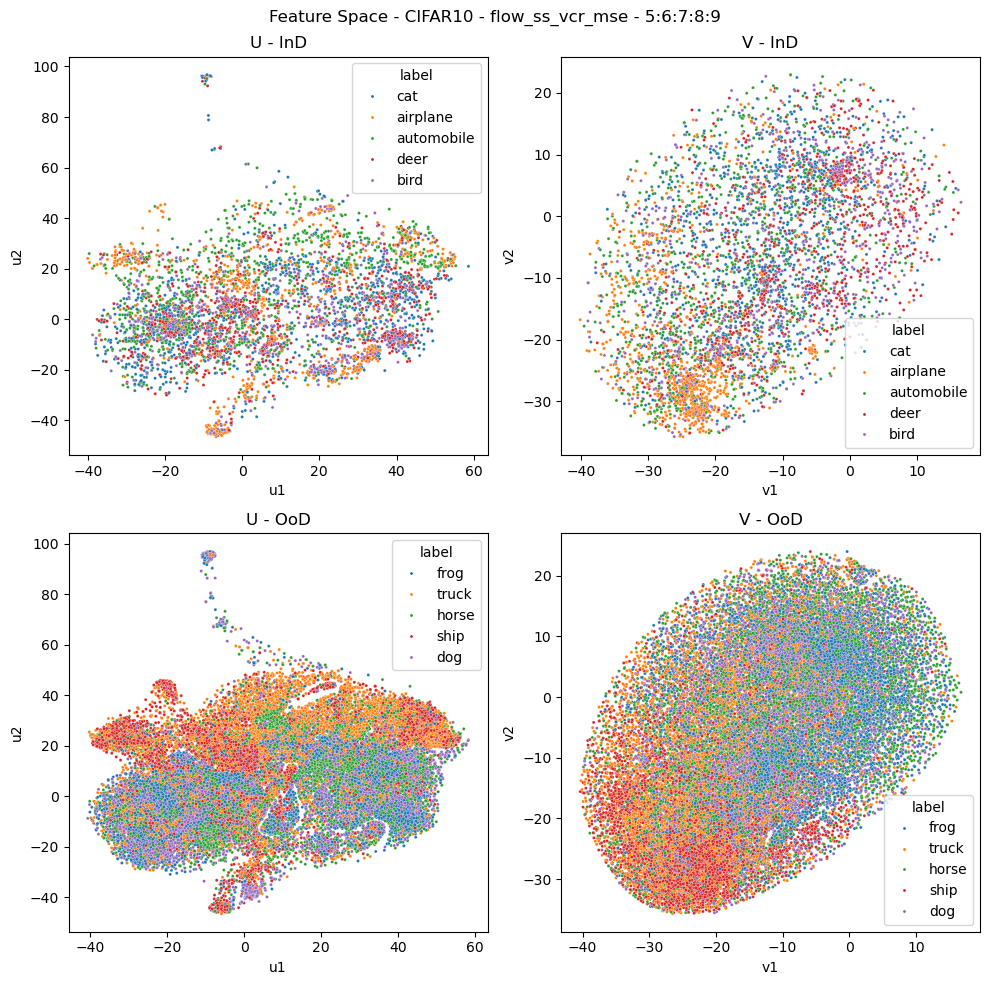

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:01<00:04,  1.38s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [00:02<00:02,  1.40s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [00:04<00:01,  1.44s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.52s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.48s/it]

  0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:05<00:17,  5.76s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [00:11<00:11,  5.78s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [00:17<00:05,  5.82s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.90s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.86s/it]

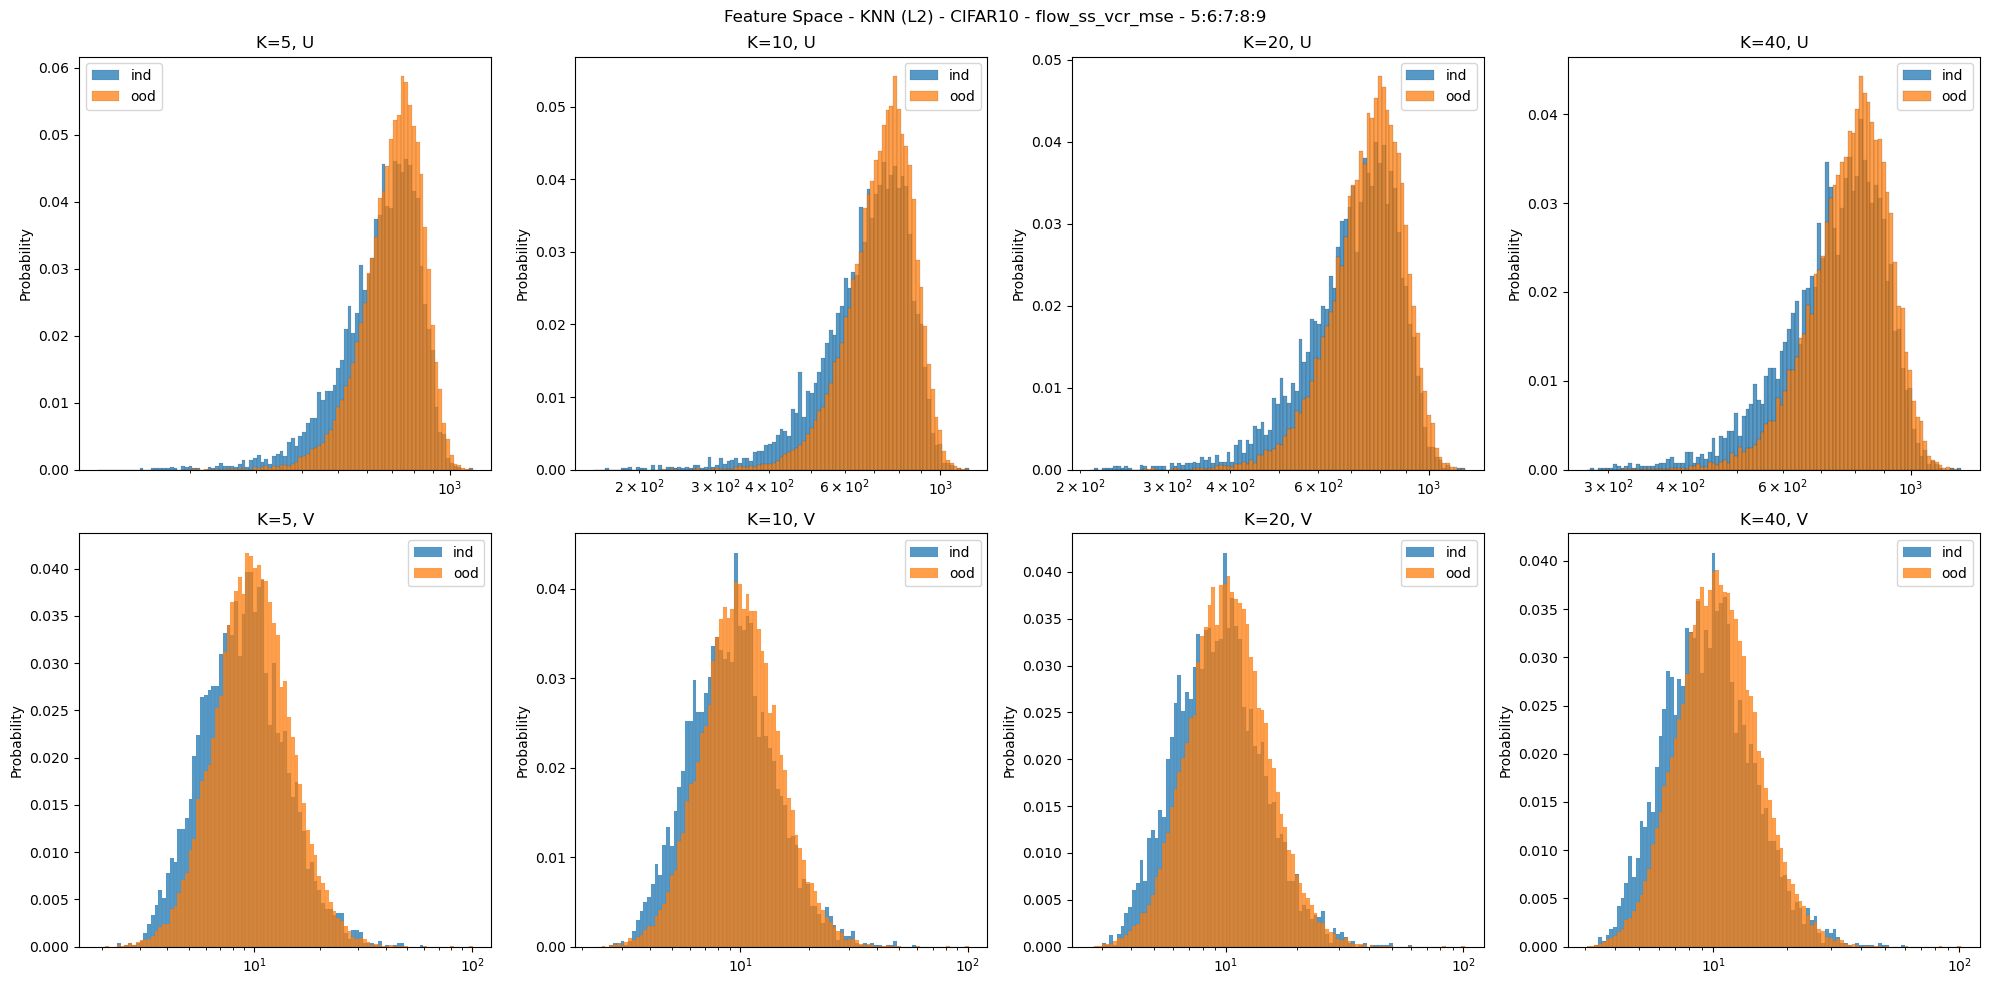

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:01<00:04,  1.34s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [00:02<00:02,  1.36s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [00:04<00:01,  1.41s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.49s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/it]

  0%|                                                                                                                                                              | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 1/4 [00:05<00:17,  5.71s/it]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 2/4 [00:11<00:11,  5.72s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3/4 [00:17<00:05,  5.88s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.91s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.87s/it]

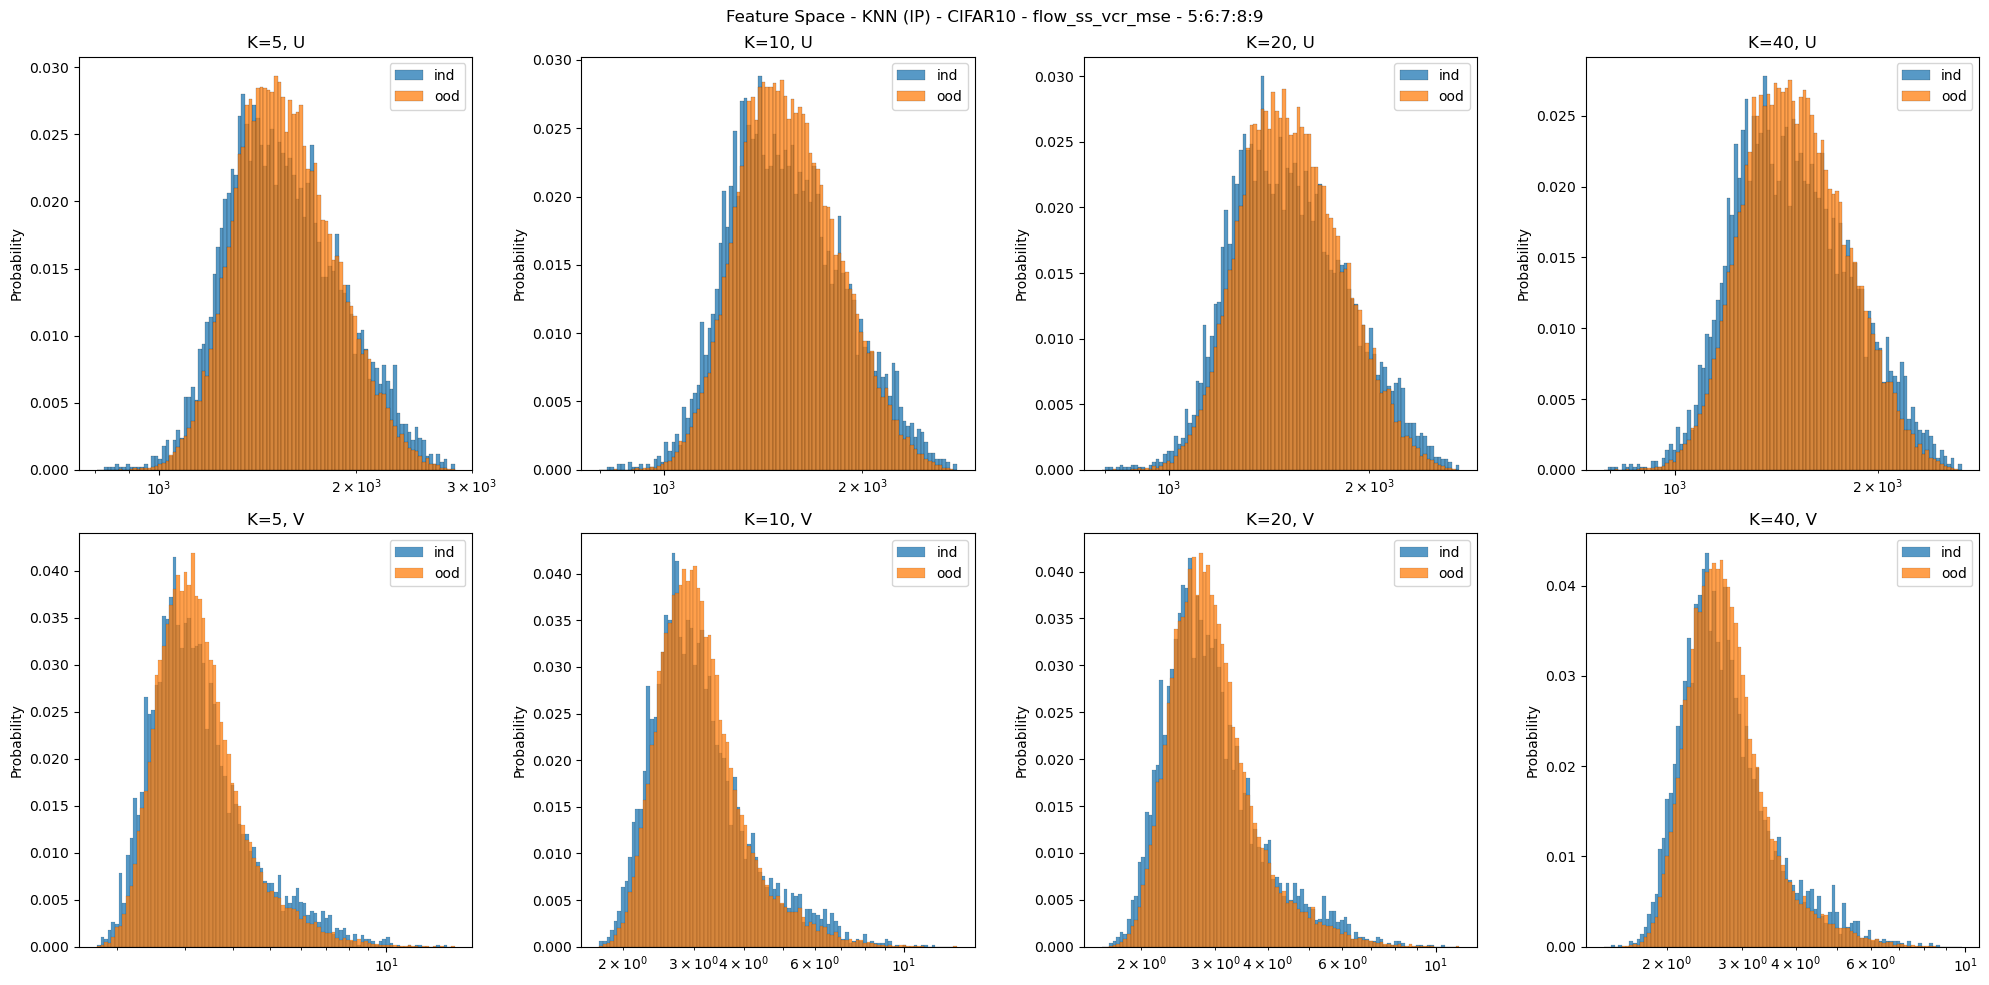

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

41.809868 3.5891087 3.067444 0.6805106
41.768356 3.6619663 3.0649757 0.6858802
41.799755 3.6667728 3.069178 0.6850388
42.142574 3.1184883 3.1870756 0.6400413
55.560265 2.374887 46.27413 0.7406803


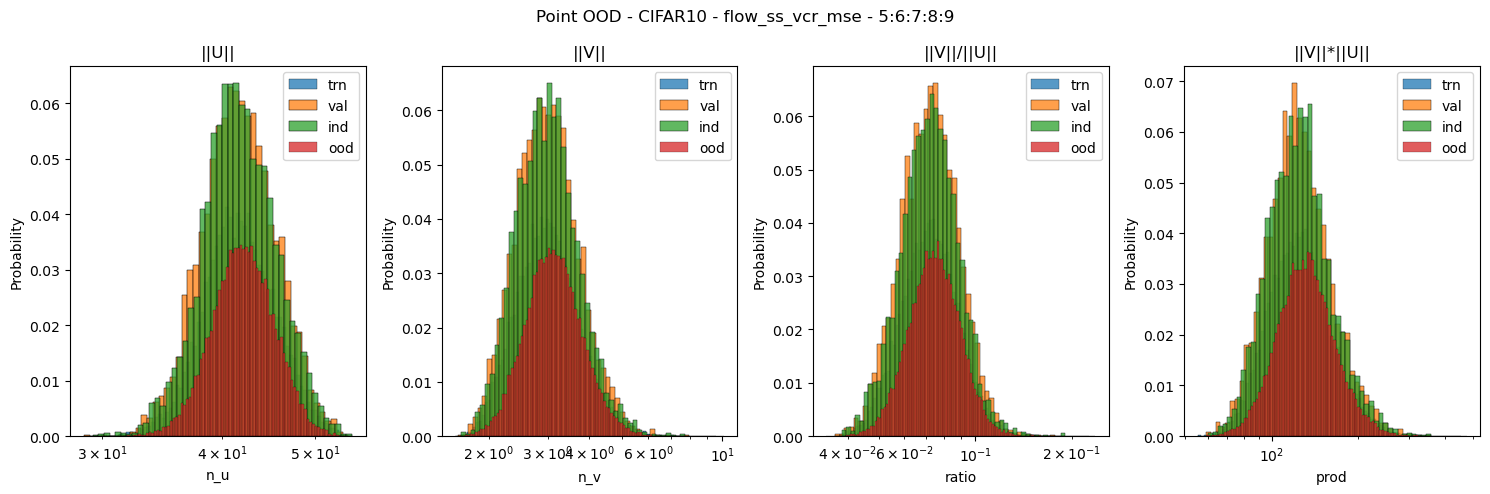

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


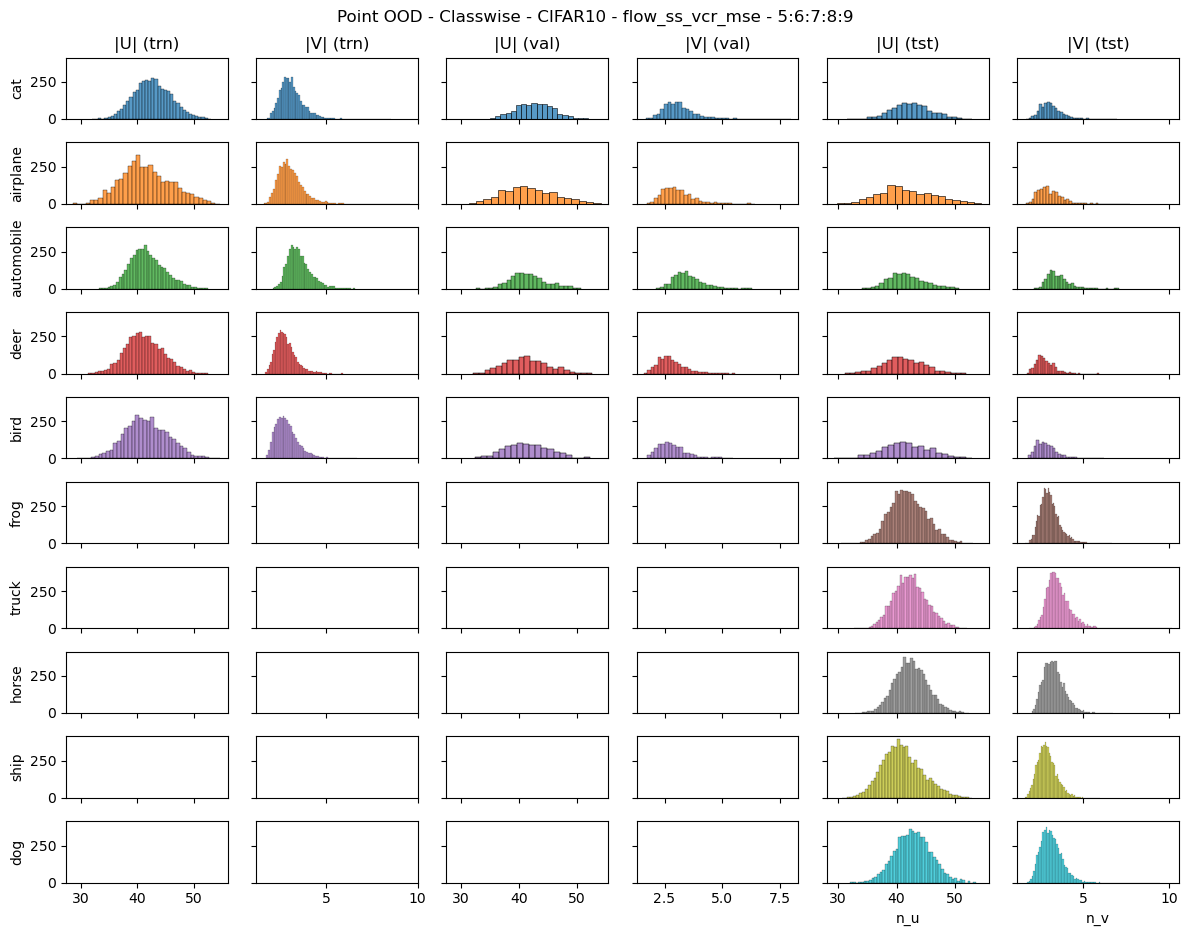

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

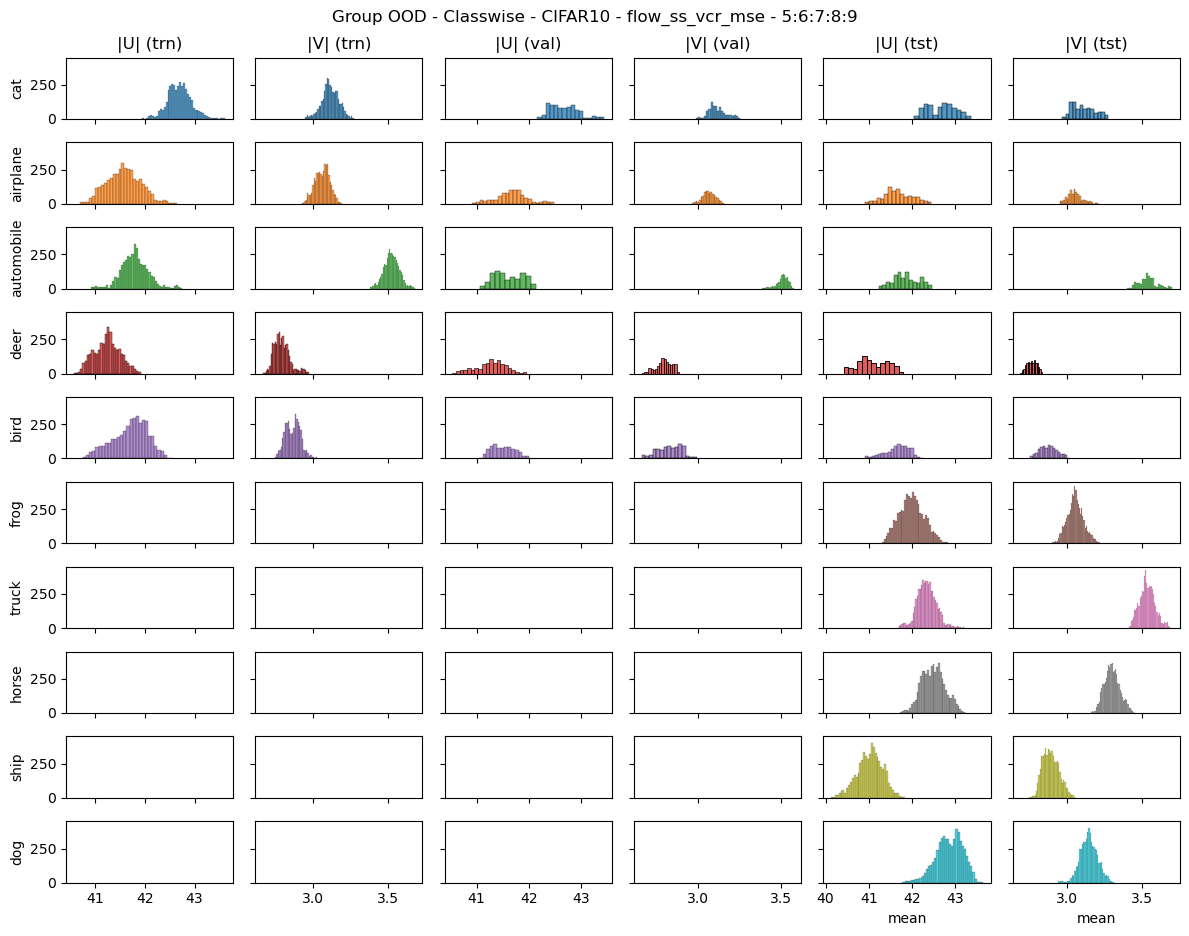

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()